In [1]:
import pandas as pd
import torch
from torch.autograd import grad
import numpy as np
## Import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import random_split,DataLoader,Subset
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor,Normalize
import warnings
warnings.filterwarnings("ignore")

## Calculating F

In [92]:
# Read the CSV file
df = pd.read_csv("coordinates_and_disp_40.csv")

# Extract relevant columns based on headings
x_coor_col = "x_coor"
y_coor_col = "y_coor"
u_x_col = "u_x"
u_y_col = "u_y"

# Extract columns as tensors
x_coor = torch.tensor(df[x_coor_col].values, dtype=torch.float32, requires_grad=True)
y_coor = torch.tensor(df[y_coor_col].values, dtype=torch.float32, requires_grad=True)
u_x = torch.tensor(df[u_x_col].values, dtype=torch.float32, requires_grad=True)
u_y = torch.tensor(df[u_y_col].values, dtype=torch.float32, requires_grad=True)

 #Print out the input tensors
print("x_coor:", x_coor)
print("y_coor:", y_coor)
print("u_x:", u_x)
print("u_y:", u_y)

# Define a function to compute the velocity based on the coordinates
def velocity_function(coordinates):
    x_coor, y_coor = coordinates.unbind(1)
    u_x = torch.tensor(df[u_x_col].values, dtype=torch.float32)
    u_y = torch.tensor(df[u_y_col].values, dtype=torch.float32)
    return torch.stack((u_x, u_y), dim=1)

# Define a function to compute the Jacobian using autograd
def compute_jacobian(x_coor, y_coor):
    # Concatenate the coordinates into a single tensor
    coordinates = torch.stack((x_coor, y_coor), dim=1)    
    # Compute the Jacobian using autograd
    Jacobian = torch.autograd.functional.jacobian(velocity_function, coordinates)
    return Jacobian

# Compute the Jacobian
Jacobian1 = compute_jacobian(x_coor, y_coor)
# Reshape the Jacobian to have shape (number of data points, 4)
Jacobian = Jacobian1.reshape(x_coor.shape[0], -1)
# Select the appropriate columns to reshape into (1438, 4)
Jacobian = Jacobian[:, :4]

I = torch.eye(2,2)
I_flattened = I.view(-1)

print(I_flattened)

# Add I to grad_u_X
F = I_flattened + Jacobian
F.shape


x_coor: tensor([0.0000, 1.0000, 1.0000,  ..., 0.9794, 0.9593, 0.0407],
       requires_grad=True)
y_coor: tensor([0.0000, 0.0000, 1.0000,  ..., 0.6109, 0.4983, 0.7369],
       requires_grad=True)
u_x: tensor([8.1634e-19, 2.0000e-01, 2.0000e-01,  ..., 1.9589e-01, 1.9187e-01,
        8.1319e-03], requires_grad=True)
u_y: tensor([0.0000, 0.0000, 0.4000,  ..., 0.2444, 0.1993, 0.2948],
       requires_grad=True)
torch.Size([1438, 4])
tensor([1., 0., 0., 1.])


## Calculating jacobian

In [33]:
# HELPER Functions for course project

def computeJacobian(F):
    """
    Compute Jacobian from deformation gradient.
    
    _Input Arguments_
    
    - `F` - deformation gradient in Voigt notation
    
    _Output Arguments_
    
    - `J` - Jacobian
    
    ---
    
    """
    F11 = F[:,0:1]
    F12 = F[:,1:2]
    F21 = F[:,2:3]
    F22 = F[:,3:4]

    J = F11*F22 - F12*F21
    return J

In [94]:
J = computeJacobian(F)

In [36]:
def computeCauchyGreenStrain(F):
    """
    Compute right Cauchy-Green strain tensor from deformation gradient.
    
    _Input Arguments_
    
    - `F` - deformation gradient in Voigt notation
    
    _Output Arguments_
    
    - `C` - Cauchy-Green strain tensor in Voigt notation
    
    ---
    
    """
    F11 = F[:,0:1]
    F12 = F[:,1:2]
    F21 = F[:,2:3]
    F22 = F[:,3:4]

    C11 = F11**2 + F21**2
    C12 = F11*F12 + F21*F22
    C21 = F11*F12 + F21*F22
    C22 = F12**2 + F22**2

    C = torch.cat((C11,C12,C21,C22),dim=1)
    return C


def computeStrainInvariants(C):
    """
    Compute invariants of the Cauchy-Green strain tensor.
    Plane strain is assumed.
    
    _Input Arguments_
    
    - `C` - Cauchy-Green strain tensor in Voigt notation
    
    _Output Arguments_
    
    - `I1` - 1st invariant
    
    - `I2` - 2nd invariant

    - `I3` - 3rd invariant

    ---
    
    """
    C11 = C[:,0:1]
    C12 = C[:,1:2]
    C21 = C[:,2:3]
    C22 = C[:,3:4]

    I1 = C11 + C22 + 1.0
    I2 = C11 + C22 - C12*C21 + C11*C22
    I3 = C11*C22 - C12*C21
    return I1, I2, I3



def computeStrainInvariantDerivatives(F,i,secondDerivative=False):
    """
    Compute derivatives of the invariants of the Cauchy-Green strain tensor with respect to the deformation gradient.
    Plane strain is assumed.
    
    _Input Arguments_
    
    - `F` - deformation gradient in Voigt notation

    - `i` - specify the invariant that should be differentiated 

    - `secondDerivative` - specify if second derivative should be computed 
    
    _Output Arguments_
    
    - `dIdF` - derivative (note that the size of `dIdF` depends on the choice of `secondDerivative`)
    
    ---
    
    """
    F11 = F[:,0:1]
    F12 = F[:,1:2]
    F21 = F[:,2:3]
    F22 = F[:,3:4]
    if not(secondDerivative):
        dIdF = torch.zeros(F.shape[0],F.shape[1])
        if(i==1):
            # dI1/dF:
            dIdF = 2.0*F
        elif(i==2):
            # dI2/dF:
            dIdF11 = 2.0*F11 - 2.0*F12*F21*F22 + 2.0*F11*(F22**2)
            dIdF12 = 2.0*F12 + 2.0*F12*(F21**2) - 2.0*F11*F21*F22
            dIdF21 = 2.0*F21 + 2.0*(F12**2)*F21 - 2.0*F11*F12*F22
            dIdF22 = 2.0*F22 - 2.0*F11*F12*F21 + 2.0*(F11**2)*F22
            dIdF = torch.cat((dIdF11,dIdF12,dIdF21,dIdF22),dim=1)
        elif(i==3):
            # dI3/dF:
            J = F11*F22 - F12*F21
            dIdF11 = 2.0*F22 * J
            dIdF12 = -2.0*F21 * J
            dIdF21 = -2.0*F12 * J
            dIdF22 = 2.0*F11 * J
            dIdF = torch.cat((dIdF11,dIdF12,dIdF21,dIdF22),dim=1)
        else:
            raise ValueError('Incorrect invariant index')
    if secondDerivative:
        dIdF = torch.zeros(F.shape[1],F.shape[1])
        if(i==1):
            # d(dI1/dF)/dF:
            dIdF = 2.0*torch.eye(F.shape[1])
        elif(i==3):
            # d(dI3/dF)/dF:
            J = F11*F22 - F12*F21
            dJdF11 = F22
            dJdF12 = - F21
            dJdF21 = - F12
            dJdF22 = F11
            # d(dI3/dF)/dF11:
            dIdF[0,0] = 2.0 * F22 * dJdF11
            dIdF[0,1] = -2.0 * F21 * dJdF11
            dIdF[0,2] = -2.0 * F12 * dJdF11
            dIdF[0,3] = 2.0 * J + 2.0 * F11 * dJdF11
            # d(dI3/dF)/dF12:
            dIdF[1,0] = 2.0 * F22 * dJdF12
            dIdF[1,1] = -2.0 * F21 * dJdF12
            dIdF[1,2] = -2.0 * J -2.0 * F12 * dJdF12
            dIdF[1,3] = 2.0 * F11 * dJdF12
            # d(dI3/dF)/dF21:
            dIdF[2,0] = 2.0 * F22 * dJdF21
            dIdF[2,1] = -2.0 * J + -2.0 * F21 * dJdF21
            dIdF[2,2] = -2.0 * F12 * dJdF21
            dIdF[2,3] = 2.0 * F11 * dJdF21
            # d(dI3/dF)/dF22:
            dIdF[3,0] = 2.0 * J + 2.0 * F22 * dJdF22
            dIdF[3,1] = -2.0 * F21 * dJdF22
            dIdF[3,2] = -2.0 * F12 * dJdF22
            dIdF[3,3] = 2.0 * F11 * dJdF22
        else:
            raise ValueError('Incorrect invariant index')
    return dIdF  


In [85]:
C = computeCauchyGreenStrain(F)
C.shape

torch.Size([1438, 4])

In [86]:
I1, I2, I3 = computeStrainInvariants(C)
I1.shape

torch.Size([1438, 1])

## Calculating 43 parameters

In [62]:
def dictionary(I1, I2, I3, J):
    I1_bar = J**(-2/3)*I1
    I2_bar = J**(-4/3)*I2
    
    a = J-1
    
    a1 = I2_bar-3
    a2 = I1_bar-3
    a3 = a1*a1
    a4 = a1*a2
    a5 = a2*a2
    a6 = a1*a1*a1
    a7 = a2*a1*a1
    a8 = a2*a2*a1
    a9 = a2*a2*a2
    a10 = a1*a1*a1*a1
    a11 = a2*a1*a1*a1
    a12 = a2*a2*a1*a1
    a13 = a2*a2*a2*a1
    a14 = a2*a2*a2*a2
    a15 = a1*a1*a1*a1*a1
    a16 = a2*a1*a1*a1*a1
    a17 = a2*a2*a1*a1*a1
    a18 = a2*a2*a2*a1*a1
    a19 = a2*a2*a2*a2*a1
    a20 = a2*a2*a2*a2*a2
    a21 = a1*a1*a1*a1*a1*a1
    a22 = a2*a1*a1*a1*a1*a1
    a23 = a2*a2*a1*a1*a1*a1
    a24 = a2*a2*a2*a1*a1*a1
    a25 = a2*a2*a2*a2*a1*a1
    a26 = a2*a2*a2*a2*a2*a1
    a27 = a2*a2*a2*a2*a2*a2
    a28 = a1*a1*a1*a1*a1*a1*a1
    a29 = a2*a1*a1*a1*a1*a1*a1
    a30 = a2*a2*a1*a1*a1*a1*a1
    a31 = a2*a2*a2*a1*a1*a1*a1
    a32 = a2*a2*a2*a2*a1*a1*a1
    a33 = a2*a2*a2*a2*a2*a1*a1
    a34 = a2*a2*a2*a2*a2*a2*a1
    a35 = a2*a2*a2*a2*a2*a2*a2
    a36 = a*a
    a37 = a36*a36
    a38 = a36*a36*a36
    a39 = a37*a37
    a40 = a39*a36
    a41 = a40*a36
    a42 = a41*a36
    a43 = torch.log(I2_bar/3)
    
    Q = torch.stack((a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,a43))
    return Q
    
    

In [64]:
Q = dictionary(I1, I2, I3, J)
Q.shape

torch.Size([43, 1438, 1])

## Calculating the strain Energy density tensor

In [65]:
## W

torch.manual_seed(42)

# Generate a 43x1 matrix with random values from a uniform distribution
beta = torch.rand(43, 1)

W = Q.T @ beta

C:\Users\91797\AppData\Local\Temp\ipykernel_15672\2592845160.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3618.)
  W = Q.T @ beta


In [66]:
W.shape

torch.Size([1, 1438, 1])

In [98]:
def P_tensor(I1,I2,I3,W,F):
    
    d1 = computeStrainInvariantDerivatives(F,1,secondDerivative=False)
    d2 = computeStrainInvariantDerivatives(F,2,secondDerivative=False)
    d3 = computeStrainInvariantDerivatives(F,3,secondDerivative=False)
    
    P = (d1+d2+d3)
    return P
    

In [99]:
P = P_tensor(I1,I2,I3,W,F)

In [112]:
n =  torch.tensor([[0,-1],[0,1],[-1,0],[1,0]],dtype=torch.float32)

In [113]:
def compute_traction(n , P):
    return P@n

In [128]:
r = compute_traction(n,P)
r.shape

torch.Size([1438, 2])

In [133]:
xx  = torch.linspace(0,1,1438) 
yy = torch.linspace(0,1,1438) 


## Calculating total Reactions

In [134]:
def Total_reaction(xx,yy,r):
    return torch.trapz(r[:,0],xx) + torch.trapz(r[:,1],yy) 
    

## Data Gathering and Preprocessing

In [13]:
class CustomDataset_1(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        inputs = torch.tensor([sample['x_coor'], sample['y_coor']], dtype=torch.float32)
        target = torch.tensor([sample['u_x'], sample['u_y']], dtype=torch.float32)
        return inputs, target

In [59]:
dfs = []
dfs1 = []
reactions = []
c = 0
for i in range(10, 70, 10):
    df_key = f"df{i}"
    r_key = f"r{i}"
    
    dfs.append(f"./exp_data/{i}/coordinates_and_disp.csv") 
    dfs1.append(pd.read_csv(f"./exp_data/{i}/coordinates_and_disp.csv"))
    reactions.append(pd.read_csv(f"./exp_data/{i}/reactions.csv"))


In [17]:
# Load the dataset
dataset_1 = CustomDataset_1(dfs[0])

# Define batch size
batch_size = len(dataset_1)

# Create data loader
train_data_loader_1 = DataLoader(dataset_1, batch_size=batch_size, shuffle=True)

## Defining the Neural Network

In [18]:
class Artificial_NN_A(nn.Module):
    def __init__(self):
        super(Artificial_NN_A, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 150),
            nn.ReLU(),
            nn.Linear(150, 150),
            nn.ReLU(),
            nn.Linear(150, 2)  # Adjust output size to 2
        )
        
    def forward(self, input_d):
        hidden_outcome = self.hidden_layers(input_d)
        return hidden_outcome  # No activation function in the final layer for regression

In [ ]:
# Training

In [19]:
def Train_Network(num_of_epochs, learning_rate, training_set):
    
    ANN = Artificial_NN_A()  

    # choosing the cross entropy loss
    loss_fn = nn.CrossEntropyLoss()

    # choose ADAM optimizer and learning rate
    optimizer = optim.Adam(ANN.parameters(), lr=learning_rate)
    
    losses = []  # List to store losses for plotting
    
    for epoch in range(num_of_epochs+1):
        
        for inputs, labels in training_set:
            
            optimizer.zero_grad()
            
            predictions = ANN(inputs)   # make predictions
            
            calc_loss = loss_fn(predictions, labels)  # calculate loss
            
            # Backprop
            calc_loss.backward()
            
            # update all the parameters
            optimizer.step()
            
            if epoch % 50 == 0:    
                print(f'Epoch {epoch}, Loss: {calc_loss.item()}')
                
            losses.append(calc_loss.item())  # Append loss for plotting
            
            if epoch == 500:
                print(f'Final_Loss: {calc_loss.item()}')
                    
    # Plotting loss versus epoch
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Cross Entropy Loss vs Epoch')
    plt.show()
    
    return ANN  # return the model

In [20]:
def Test_Network(test_set, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_set:
            predictions = model(inputs)
    
    return predictions

Epoch 0, Loss: 0.051902636885643005
Epoch 50, Loss: 0.040606338530778885
Epoch 100, Loss: 0.0400821752846241
Epoch 150, Loss: 0.039936162531375885
Epoch 200, Loss: 0.03989003598690033
Epoch 250, Loss: 0.03986344859004021
Epoch 300, Loss: 0.039845772087574005
Epoch 350, Loss: 0.0398331955075264
Epoch 400, Loss: 0.0398237518966198
Epoch 450, Loss: 0.039816390722990036
Epoch 500, Loss: 0.039810433983802795
Final_Loss: 0.039810433983802795


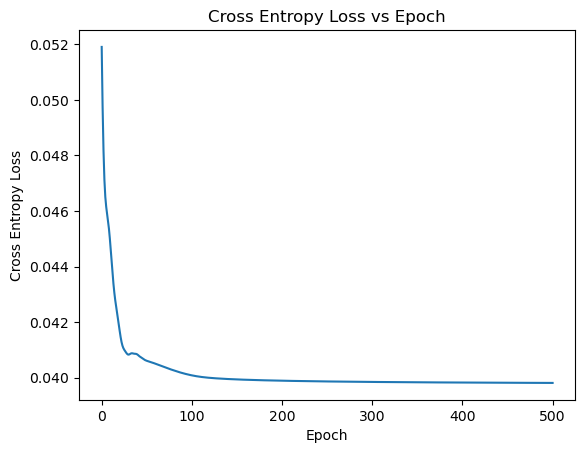

In [21]:
trained_model_1 = Train_Network(500,0.001,train_data_loader_1)

In [24]:
u_pred = Test_Network(train_data_loader_1, trained_model_1) 

In [44]:
u_0 = torch.tensor([dfs1[0]['u_x'], dfs1[0]['u_y']], dtype=torch.float32).T

In [39]:
f = torch.tensor([dfs1[0]['u_x_low'], dfs1[0]['u_y_low']], dtype=torch.float32).T
f

tensor([[-1.9259e-05,  2.3097e-07],
        [ 5.0001e-02,  1.1668e-05],
        [ 4.9999e-02,  1.0000e-01],
        ...,
        [ 4.8974e-02,  6.1099e-02],
        [ 4.7970e-02,  4.9836e-02],
        [ 2.0346e-03,  7.3698e-02]])

In [42]:
uf_pred = u_pred+f

## Boundary and Experimental loss

In [71]:
def J_BC(uf0_pred , u0 , ut_pred , ut):
    val = 0
    uf0_pred = uf0_pred.flatten()
    u0 = u0.flatten()
    ut_pred = ut_pred.flatten()
    ut = ut.flatten()
    for i in range(136):
        val += (uf0_pred[i]-u0[i])**2 + (ut_pred[i]-ut[i])**2
    val /= 136
    return val.item()

In [72]:
J_BC(uf_pred , u_0 , uf_pred , u_0)

1.3894702196121216

In [73]:
def exp_loss(ut_pred, ut):
    ut_pred = ut_pred.flatten()
    ut = ut.flatten()
    val = 0
    for i in range(137,1438,1):
        val += (ut_pred[i]-ut[i])**2
    val /= (1302)
    return val.item()

In [74]:
exp_loss(uf_pred, u_0)

0.6810752153396606